In [34]:
#auto reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import os.path as osp
import random
from typing import Dict,List

import gym.spaces as spaces
import hydra
import numpy as np
import torch
from hydra.utils import instantiate as hydra_instantiate
from omegaconf import DictConfig
from rl_utils.envs import create_vectorized_envs
from rl_utils.logging import Logger
from tensordict.tensordict import TensorDict
from torchrl.envs.utils import step_mdp
from typing import Tuple
from imitation_learning.common.evaluator import Evaluator

In [36]:
from snake_env import SnakeEnv 

In [37]:
import yaml 
cfg = yaml.load(open("bc-irl-snake.yaml", 'r'), Loader=yaml.SafeLoader)
cfg = DictConfig(cfg)

In [38]:
cfg

{'env_settings': {}, 'obs_shape': '???', 'action_dim': '???', 'total_num_updates': '???', 'action_is_discrete': '???', 'num_steps': 25, 'num_envs': 256, 'device': 'cpu', 'only_eval': False, 'seed': 3, 'num_eval_episodes': 100, 'num_env_steps': 5000000, 'recurrent_hidden_state_size': 128, 'gamma': 0.99, 'log_interval': 10, 'eval_interval': 500, 'save_interval': 10000000000, 'load_checkpoint': None, 'load_policy': True, 'resume_training': False, 'policy': {'_target_': 'imitation_learning.policy_opt.policy.Policy', 'hidden_size': 128, 'recurrent_hidden_size': 128, 'is_recurrent': False, 'obs_shape': '${obs_shape}', 'action_dim': '${action_dim}', 'action_is_discrete': '${action_is_discrete}', 'std_init': 0, 'num_envs': '${num_envs}'}, 'policy_updater': {'_target_': 'imitation_learning.bcirl.BCIRL', '_recursive_': False, 'use_clipped_value_loss': True, 'clip_param': 0.2, 'value_loss_coef': 0.5, 'entropy_coef': 0.0001, 'max_grad_norm': 0.5, 'num_epochs': 2, 'num_mini_batch': 4, 'num_envs': '

In [39]:

def set_seed(seed: int) -> None:
    """
    Sets the seed for numpy, python random, and pytorch.
    """
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [40]:
from gymnasium import Env
class vectorized_env():
    def __init__(self, envs : List[Env]):
        self.envs = envs
        self.num_envs = len(self.envs)
        self.observation_space = self.envs[0].observation_space
        self.action_space = self.envs[0].action_space

    def reset(self):

        return torch.tensor([env.reset()[0].tolist() for env in self.envs],dtype=torch.float32)
    
    def step(self, action) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, List[Dict]]:
        steps = [env.step(action[i]) for i,env in enumerate(self.envs)]
        return_value = (torch.tensor([step[0].tolist() for step in steps],dtype=torch.float32),
                torch.tensor([step[1] for step in steps],dtype=torch.float32),
                torch.tensor([step[2] for step in steps],dtype=torch.bool),
                [step[3] for step in steps])
        return return_value
    
    def render(self, mode = "rgb_array"):
        if(self.envs[0].render_mode == "rgb_array"):
            return [env.render(mode) for env in self.envs]
        else:
            self.envs[0].render(mode)

In [41]:
set_seed(cfg.seed)

device = torch.device(cfg.device)

# Setup the environments
set_env_settings = {
    k: hydra_instantiate(v) if isinstance(v, DictConfig) else v
    for k, v in cfg.env.env_settings.items()
}
envs = vectorized_env([SnakeEnv(cfg.env.env_settings.params.config) for _ in range(cfg.num_envs)])

steps_per_update = cfg.num_steps * cfg.num_envs

num_updates = int(cfg.num_env_steps) // steps_per_update

# Set dynamic variables in the config.
cfg.obs_shape = envs.observation_space.shape
cfg.action_dim = envs.action_space.shape[0]
cfg.action_is_discrete = isinstance(cfg.action_dim, spaces.Discrete)
cfg.total_num_updates = num_updates

logger: Logger = hydra_instantiate(cfg.logger, full_cfg=cfg)
print("policy",cfg.policy)
policy = hydra_instantiate(cfg.policy)
policy = policy.to(device)
print("policy_updater",cfg.policy_updater)
updater = hydra_instantiate(cfg.policy_updater, policy=policy, device=device).to(device)


Assigning full prefix 64-3-HfuzZX
policy {'_target_': 'imitation_learning.policy_opt.policy.Policy', 'hidden_size': 128, 'recurrent_hidden_size': 128, 'is_recurrent': False, 'obs_shape': [202], 'action_dim': 4, 'action_is_discrete': False, 'std_init': 0, 'num_envs': 256}
policy_updater {'_target_': 'imitation_learning.bcirl.BCIRL', '_recursive_': False, 'use_clipped_value_loss': True, 'clip_param': 0.2, 'value_loss_coef': 0.5, 'entropy_coef': 0.0001, 'max_grad_norm': 0.5, 'num_epochs': 2, 'num_mini_batch': 4, 'num_envs': '${num_envs}', 'num_steps': '${num_steps}', 'gae_lambda': 0.95, 'gamma': '${gamma}', 'optimizer_params': {'_target_': 'torch.optim.Adam', 'lr': 0.0003}, 'batch_size': 256, 'plot_interval': '${eval_interval}', 'norm_expert_actions': False, 'n_inner_iters': 1, 'reward_update_freq': 1, 'device': '${device}', 'total_num_updates': '${total_num_updates}', 'use_lr_decay': False, 'get_dataset_fn': {'_target_': 'imitation_learning.common.utils.get_transition_dataset', 'dataset_

In [42]:

start_update = 0
if cfg.load_checkpoint is not None:
    # Load a checkpoint for the policy/reward. Also potentially resume
    # training.
    ckpt = torch.load(cfg.load_checkpoint)
    updater.load_state_dict(ckpt["updater"], should_load_opt=cfg.resume_training)
    if cfg.load_policy:
        policy.load_state_dict(ckpt["policy"])
    if cfg.resume_training:
        start_update = ckpt["update_i"] + 1

eval_info = {"run_name": logger.run_name}


In [43]:
import warnings 
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


Updates 0, Steps 6400, FPS 5114
Over the last 10 episodes:
    - episode.reward: -0.3794625262130781
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3203422147069209
    - inferred_episode_reward: 0.5276395007967949
    - value_loss: 0.05819609807804227
    - action_loss: 0.012485607207054272
    - dist_entropy: 5.675752639770508
    - irl_loss: 0.3077068030834198


<Figure size 640x480 with 0 Axes>

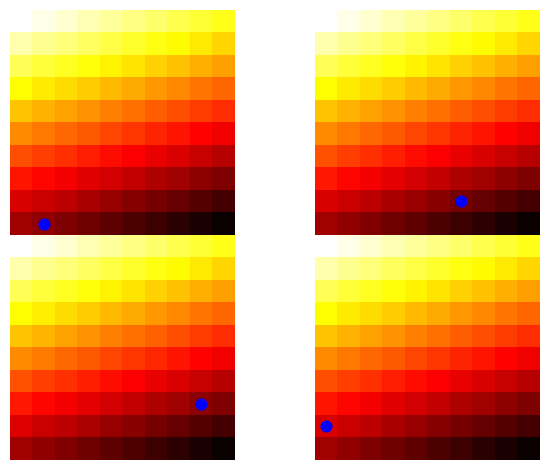


Updates 10, Steps 70400, FPS 9560
Over the last 10 episodes:
    - episode.reward: 0.0005242641940741116
    - episode.score: 0.0
    - episode.distance_to_goal: 0.32715879399041436
    - inferred_episode_reward: 1.7289148181676866
    - value_loss: 1.1684942603111268
    - action_loss: -0.009515781491063535
    - dist_entropy: 5.6759538650512695
    - irl_loss: 0.32220775783061983


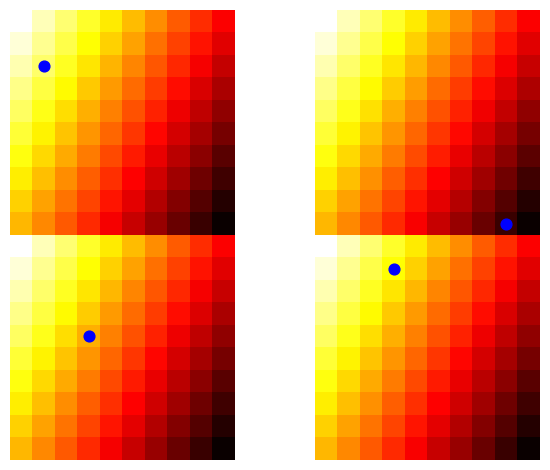


Updates 20, Steps 134400, FPS 9421
Over the last 10 episodes:
    - episode.reward: -0.057858071214433
    - episode.score: 0.0
    - episode.distance_to_goal: 0.363950246396728
    - inferred_episode_reward: 1.9126447409391403
    - value_loss: 1.2954428315162658
    - action_loss: 0.002864211262203753
    - dist_entropy: 5.675485420227051
    - irl_loss: 0.312285789847374


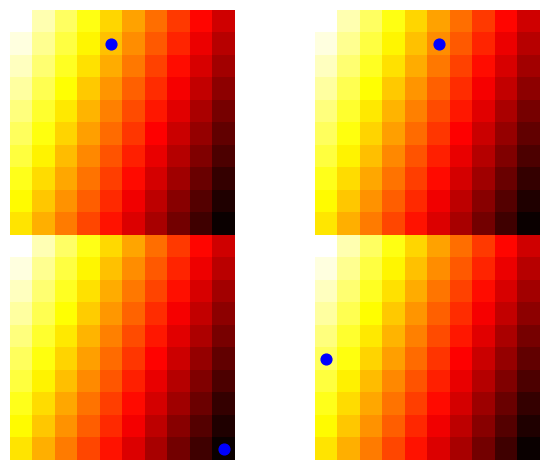


Updates 30, Steps 198400, FPS 10384
Over the last 10 episodes:
    - episode.reward: -0.04615336943852584
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4476251013692122
    - inferred_episode_reward: 4.848592203855515
    - value_loss: 0.9402835249900818
    - action_loss: 0.0021208318532444535
    - dist_entropy: 5.6761627197265625
    - irl_loss: 0.3058151215314865


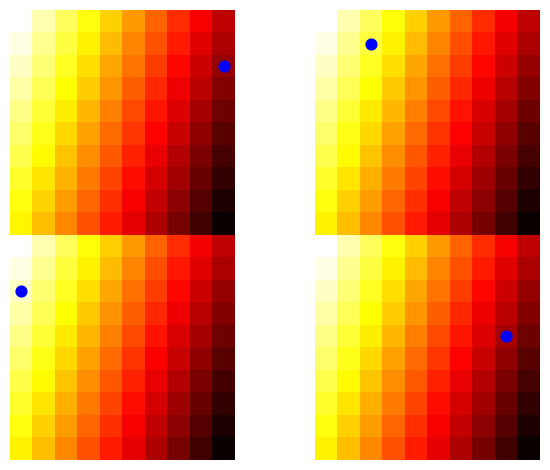


Updates 40, Steps 262400, FPS 10032
Over the last 10 episodes:
    - episode.reward: -0.2689802266974376
    - episode.score: 0.0
    - episode.distance_to_goal: 0.38954390218505563
    - inferred_episode_reward: 1.2965426325798035
    - value_loss: 0.5517441928386688
    - action_loss: -0.0012853426815127023
    - dist_entropy: 5.676123046875
    - irl_loss: 0.30330286622047425


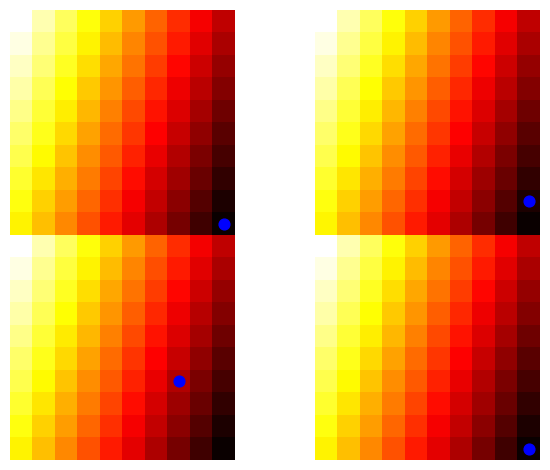


Updates 50, Steps 326400, FPS 10086
Over the last 10 episodes:
    - episode.reward: -0.1683855667805359
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3640632846025401
    - inferred_episode_reward: 0.7421242356300354
    - value_loss: 0.23045714497566222
    - action_loss: -0.00766151649877429
    - dist_entropy: 5.67640323638916
    - irl_loss: 0.3001318722963333


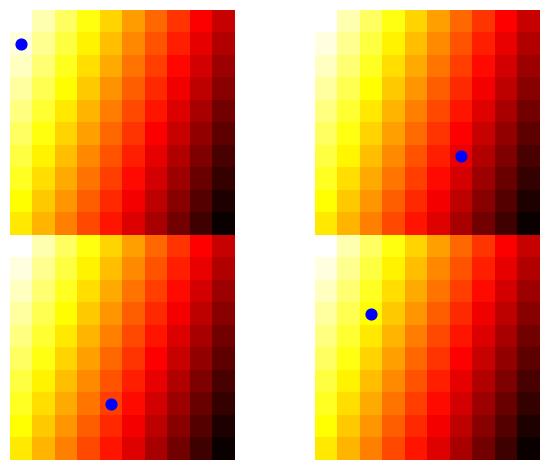


Updates 60, Steps 390400, FPS 10264
Over the last 10 episodes:
    - episode.reward: -0.18400999775860172
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4272996024954069
    - inferred_episode_reward: 1.7471960021182895
    - value_loss: 0.42424928247928617
    - action_loss: -0.006481079978402704
    - dist_entropy: 5.675884628295899
    - irl_loss: 0.2960507720708847


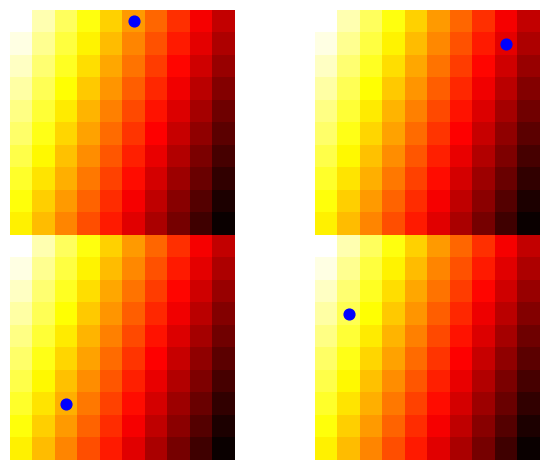


Updates 70, Steps 454400, FPS 9738
Over the last 10 episodes:
    - episode.reward: -0.14102585716942112
    - episode.score: 0.0
    - episode.distance_to_goal: 0.29055184583752014
    - inferred_episode_reward: 2.873998633027077
    - value_loss: 0.7868282079696656
    - action_loss: 0.0018646539654582738
    - dist_entropy: 5.676203918457031
    - irl_loss: 0.2945517748594284


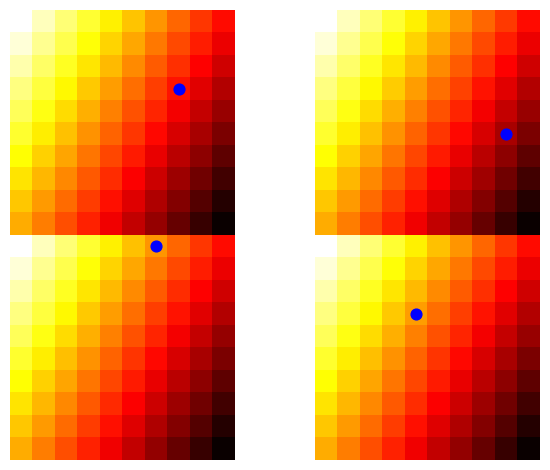


Updates 80, Steps 518400, FPS 9527
Over the last 10 episodes:
    - episode.reward: -0.46886661747788116
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3715717664158492
    - inferred_episode_reward: 1.0593118831515311
    - value_loss: 0.815991473197937
    - action_loss: 0.0026972257415764033
    - dist_entropy: 5.675444507598877
    - irl_loss: 0.29690811932086947


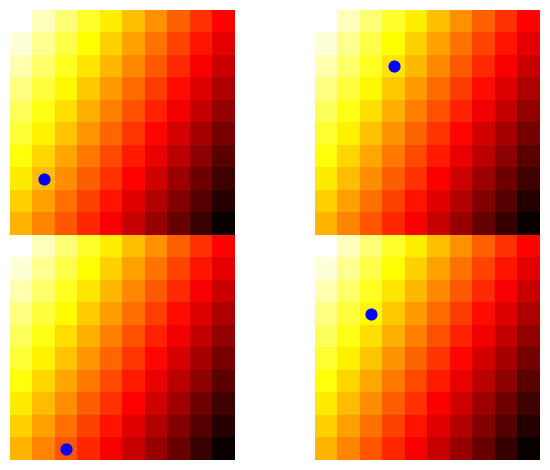


Updates 90, Steps 582400, FPS 9695
Over the last 10 episodes:
    - episode.reward: -0.30774891159205486
    - episode.score: 0.0
    - episode.distance_to_goal: 0.28752732381926094
    - inferred_episode_reward: 2.3269291162490844
    - value_loss: 0.6752386331558228
    - action_loss: -0.005361744202673435
    - dist_entropy: 5.674523258209229
    - irl_loss: 0.29431064426898956


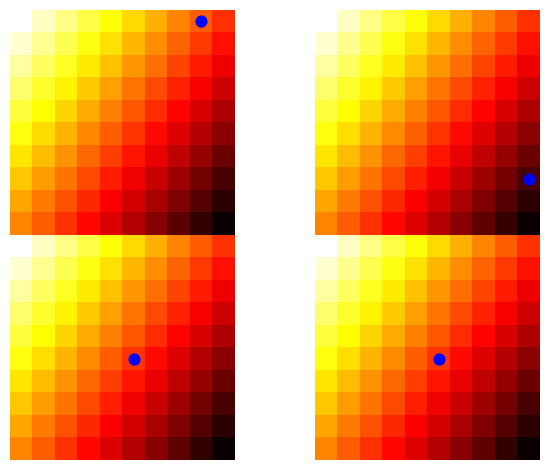


Updates 100, Steps 646400, FPS 9759
Over the last 10 episodes:
    - episode.reward: -0.19634813904626816
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3367235554925271
    - inferred_episode_reward: 2.0538492374122144
    - value_loss: 0.8391740202903748
    - action_loss: -0.004179340810514987
    - dist_entropy: 5.673844623565674
    - irl_loss: 0.2914437860250473


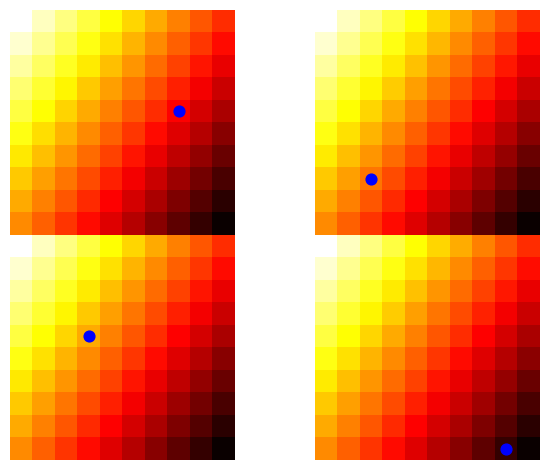


Updates 110, Steps 710400, FPS 9763
Over the last 10 episodes:
    - episode.reward: -0.13690269271036426
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3082426771017043
    - inferred_episode_reward: 3.812040403485298
    - value_loss: 1.5665370345115661
    - action_loss: -0.0019232140271924435
    - dist_entropy: 5.673764705657959
    - irl_loss: 0.2955259919166565


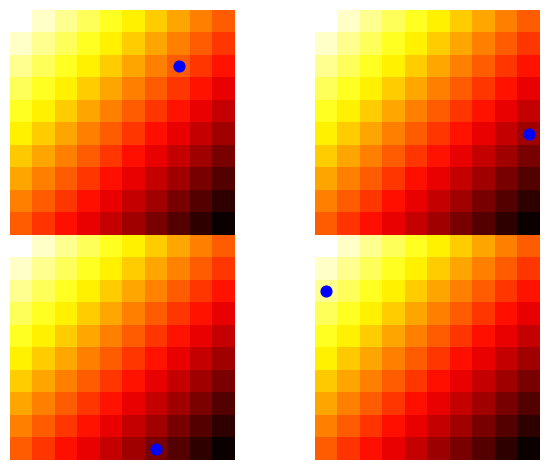


Updates 120, Steps 774400, FPS 9802
Over the last 10 episodes:
    - episode.reward: -0.057347926159976095
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4062750710205611
    - inferred_episode_reward: 2.2988933697342873
    - value_loss: 1.6527274131774903
    - action_loss: -0.0026720189955085514
    - dist_entropy: 5.673764705657959
    - irl_loss: 0.2899634301662445


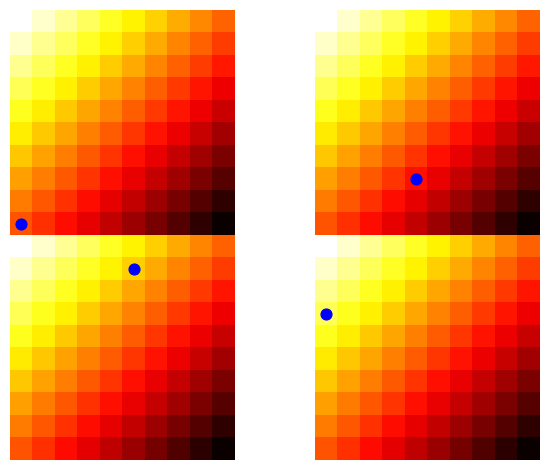


Updates 130, Steps 838400, FPS 9713
Over the last 10 episodes:
    - episode.reward: -0.0542066081720601
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3714434850438918
    - inferred_episode_reward: 6.005449628829956
    - value_loss: 1.908829140663147
    - action_loss: -0.002506588655523956
    - dist_entropy: 5.674164295196533
    - irl_loss: 0.28826716244220735


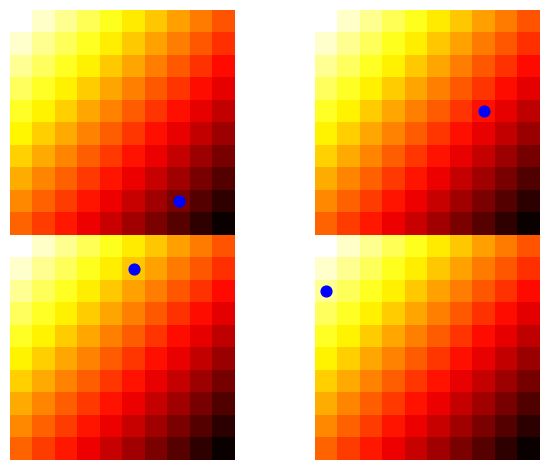


Updates 140, Steps 902400, FPS 9800
Over the last 10 episodes:
    - episode.reward: -0.14268866084401438
    - episode.score: 0.0
    - episode.distance_to_goal: 0.35854339004152824
    - inferred_episode_reward: 3.9753223776817324
    - value_loss: 1.7337562561035156
    - action_loss: -0.0012677381397224962
    - dist_entropy: 5.673964977264404
    - irl_loss: 0.29080803990364074


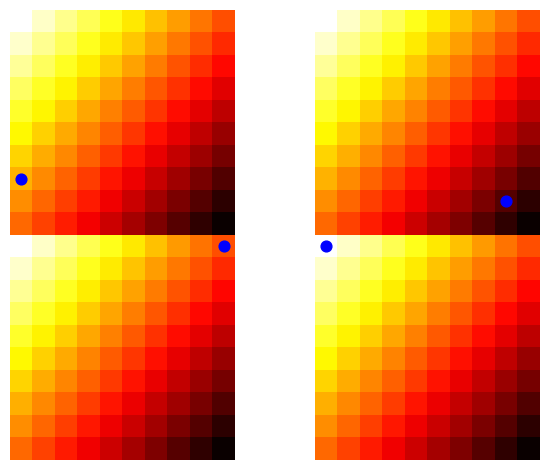


Updates 150, Steps 966400, FPS 9771
Over the last 10 episodes:
    - episode.reward: -0.24366625158919591
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4797730115898817
    - inferred_episode_reward: 3.791002929210663
    - value_loss: 2.1151458501815794
    - action_loss: -0.012366957357153296
    - dist_entropy: 5.674724674224853
    - irl_loss: 0.28749910593032835


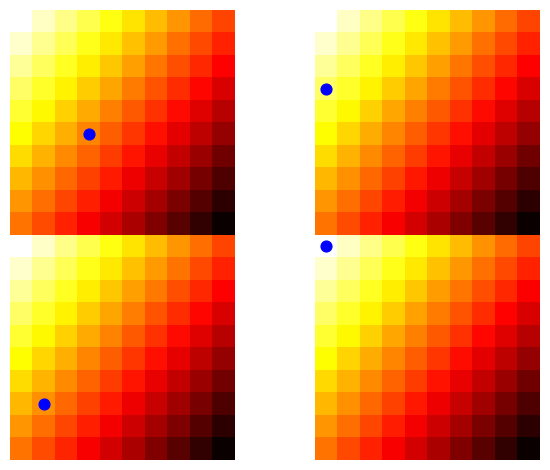


Updates 160, Steps 1030400, FPS 9889
Over the last 10 episodes:
    - episode.reward: -0.15938794580549667
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3534552046371846
    - inferred_episode_reward: 3.2750793159008027
    - value_loss: 2.4318533658981325
    - action_loss: -0.0001847587525844574
    - dist_entropy: 5.67552547454834
    - irl_loss: 0.2910516560077667


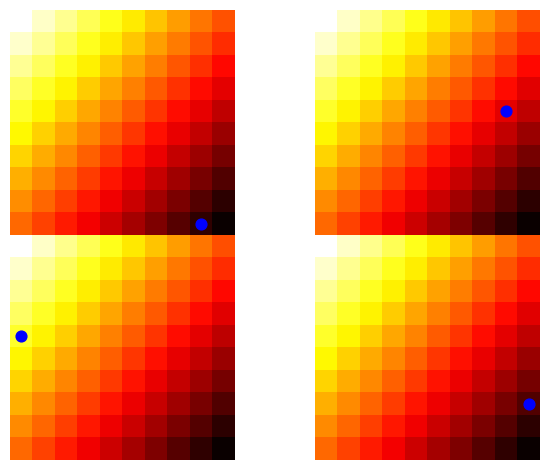


Updates 170, Steps 1094400, FPS 9710
Over the last 10 episodes:
    - episode.reward: -0.03327948386805375
    - episode.score: 0.1
    - episode.distance_to_goal: 0.3314758591794186
    - inferred_episode_reward: 4.5053041011095045
    - value_loss: 2.7903958559036255
    - action_loss: -0.0008932401426136494
    - dist_entropy: 5.6740447044372555
    - irl_loss: 0.28233487606048585


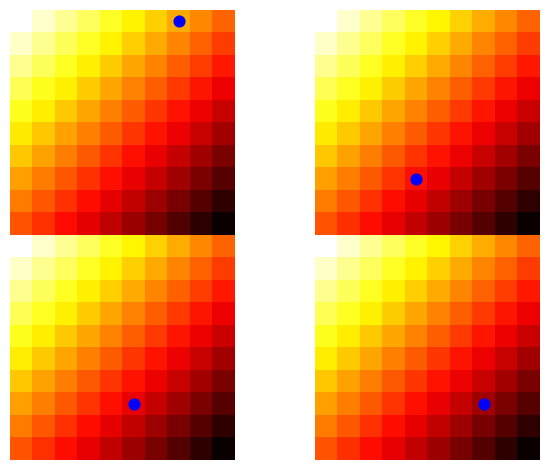


Updates 180, Steps 1158400, FPS 9794
Over the last 10 episodes:
    - episode.reward: -0.12379793845768217
    - episode.score: 0.0
    - episode.distance_to_goal: 0.27683382004661744
    - inferred_episode_reward: 3.2642668694257737
    - value_loss: 3.1002506494522093
    - action_loss: 0.011397675517946482
    - dist_entropy: 5.673764705657959
    - irl_loss: 0.28843353390693666


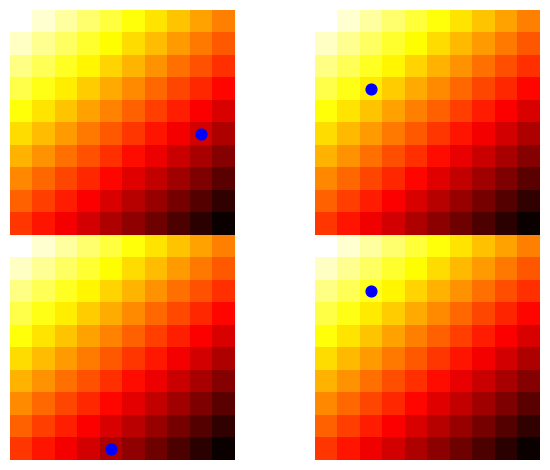


Updates 190, Steps 1222400, FPS 9734
Over the last 10 episodes:
    - episode.reward: -0.08513458802575895
    - episode.score: 0.0
    - episode.distance_to_goal: 0.38852688146004294
    - inferred_episode_reward: 6.545706856250763
    - value_loss: 3.6712244749069214
    - action_loss: 0.004845268093049526
    - dist_entropy: 5.674164295196533
    - irl_loss: 0.28872851729393006


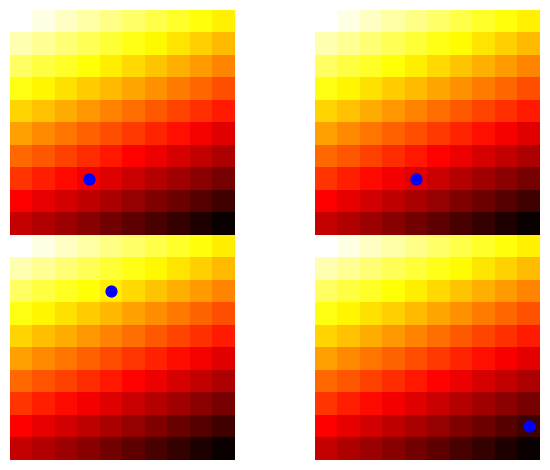


Updates 200, Steps 1286400, FPS 9796
Over the last 10 episodes:
    - episode.reward: -0.3691009655690731
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4654225291815216
    - inferred_episode_reward: 5.32284574508667
    - value_loss: 4.290469074249268
    - action_loss: -0.0015484588919207453
    - dist_entropy: 5.6740447044372555
    - irl_loss: 0.29578963220119475


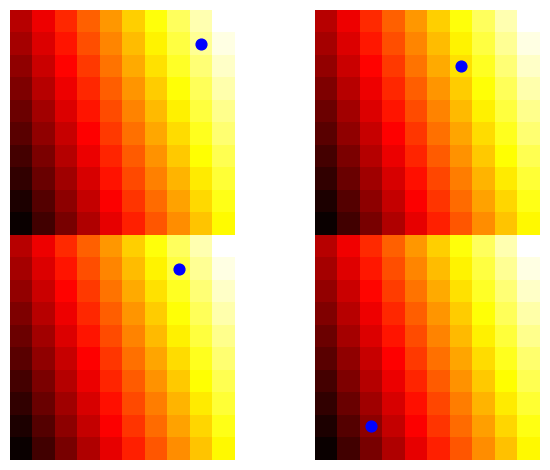


Updates 210, Steps 1350400, FPS 9791
Over the last 10 episodes:
    - episode.reward: -0.026853480012277754
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3224981997598101
    - inferred_episode_reward: 8.427679061889648
    - value_loss: 4.637098932266236
    - action_loss: 0.0012222217745147645
    - dist_entropy: 5.674164295196533
    - irl_loss: 0.29382042586803436


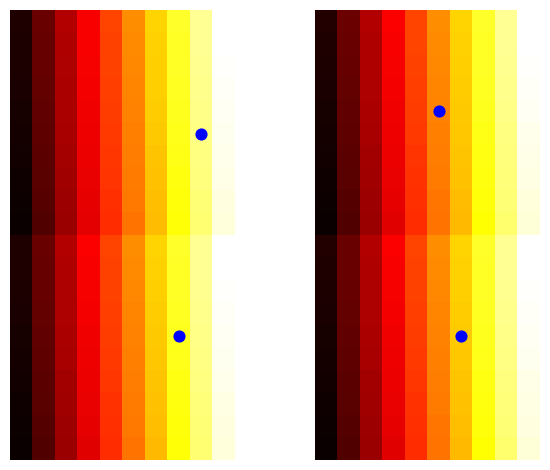


Updates 220, Steps 1414400, FPS 9729
Over the last 10 episodes:
    - episode.reward: -0.19530583352447187
    - episode.score: 0.0
    - episode.distance_to_goal: 0.33233189981203115
    - inferred_episode_reward: 4.330101603269577
    - value_loss: 3.9223963022232056
    - action_loss: 0.001195175340399146
    - dist_entropy: 5.673724555969239
    - irl_loss: 0.2944891691207886


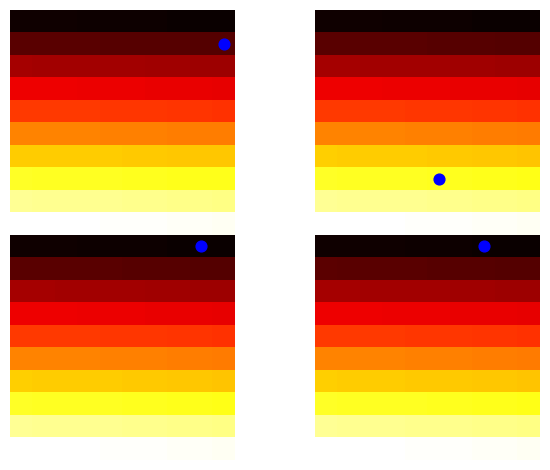


Updates 230, Steps 1478400, FPS 9862
Over the last 10 episodes:
    - episode.reward: -0.3580885074843874
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4284587532722092
    - inferred_episode_reward: 4.7793935328722
    - value_loss: 3.263814091682434
    - action_loss: 0.005768228103988804
    - dist_entropy: 5.674363613128662
    - irl_loss: 0.3025161027908325


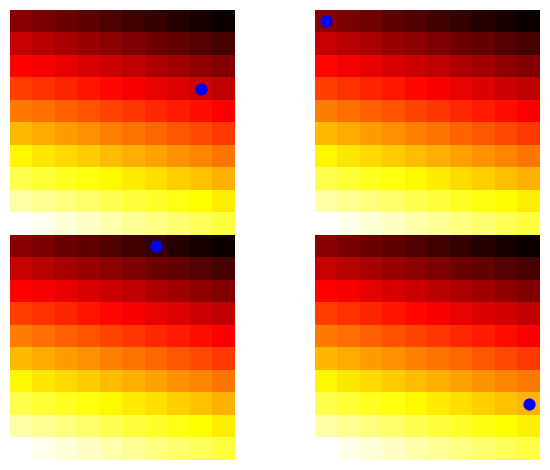


Updates 240, Steps 1542400, FPS 9746
Over the last 10 episodes:
    - episode.reward: -0.22601316990424417
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3303643796539678
    - inferred_episode_reward: 4.741900384426117
    - value_loss: 2.884417700767517
    - action_loss: 0.005437368276761845
    - dist_entropy: 5.674164295196533
    - irl_loss: 0.3001628667116165


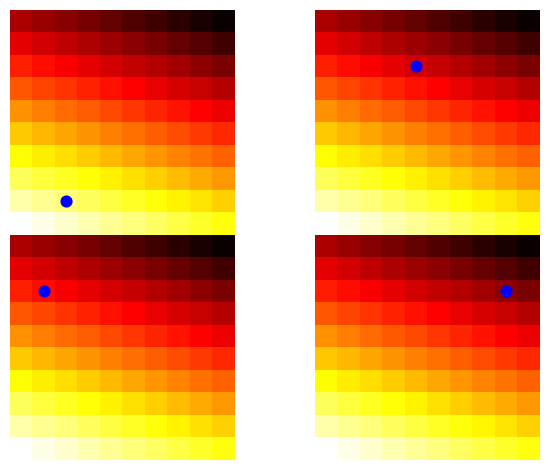


Updates 250, Steps 1606400, FPS 9610
Over the last 10 episodes:
    - episode.reward: -0.1799292467763753
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3596866127848755
    - inferred_episode_reward: 5.456686788797379
    - value_loss: 2.550910210609436
    - action_loss: -0.006747749005444348
    - dist_entropy: 5.67496395111084
    - irl_loss: 0.3033390462398529


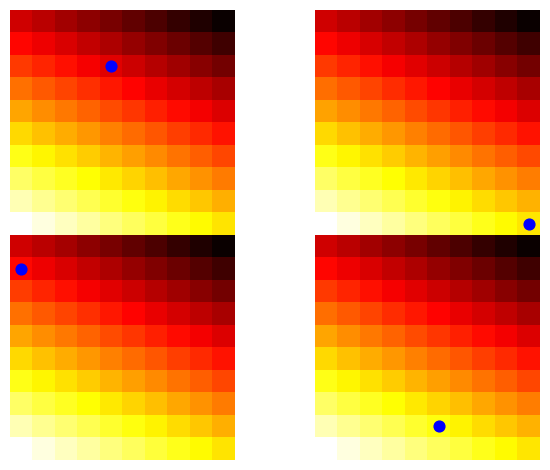


Updates 260, Steps 1670400, FPS 9731
Over the last 10 episodes:
    - episode.reward: -0.28376215352863243
    - episode.score: 0.0
    - episode.distance_to_goal: 0.36885864703522386
    - inferred_episode_reward: 2.1548610478639603
    - value_loss: 2.388772177696228
    - action_loss: 0.022238786146044732
    - dist_entropy: 5.675003623962402
    - irl_loss: 0.2947130352258682


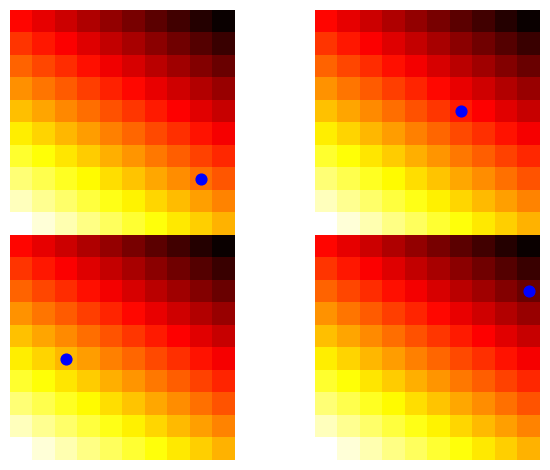


Updates 270, Steps 1734400, FPS 9820
Over the last 10 episodes:
    - episode.reward: -0.38356587279483706
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4653198525818344
    - inferred_episode_reward: 3.267037031054497
    - value_loss: 4.333962845802307
    - action_loss: 0.0056683260947465895
    - dist_entropy: 5.674603080749511
    - irl_loss: 0.29904927015304567


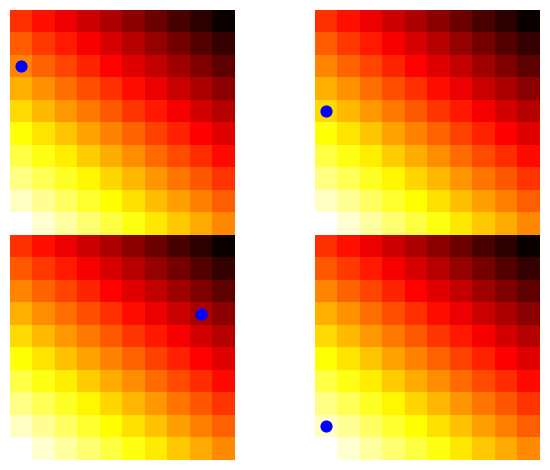


Updates 280, Steps 1798400, FPS 9673
Over the last 10 episodes:
    - episode.reward: -0.04041291077038629
    - episode.score: 0.0
    - episode.distance_to_goal: 0.32142400214311984
    - inferred_episode_reward: 5.375805819034577
    - value_loss: 6.021571683883667
    - action_loss: -0.025517513602972032
    - dist_entropy: 5.674522876739502
    - irl_loss: 0.29620552957057955


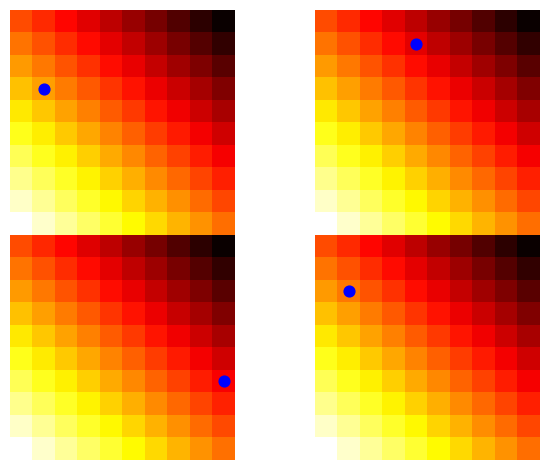


Updates 290, Steps 1862400, FPS 9830
Over the last 10 episodes:
    - episode.reward: -0.26671726189591344
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3103938939376521
    - inferred_episode_reward: 10.410029524564743
    - value_loss: 7.515945720672607
    - action_loss: 0.004452424147166312
    - dist_entropy: 5.673403739929199
    - irl_loss: 0.3064635843038559


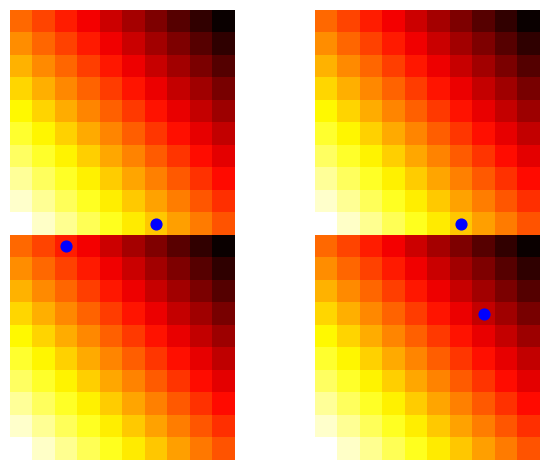


Updates 300, Steps 1926400, FPS 9677
Over the last 10 episodes:
    - episode.reward: -0.26960081679703096
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3473660945903996
    - inferred_episode_reward: 16.115243864059448
    - value_loss: 8.728659534454346
    - action_loss: -0.00705099263577722
    - dist_entropy: 5.672802925109863
    - irl_loss: 0.3045563578605652


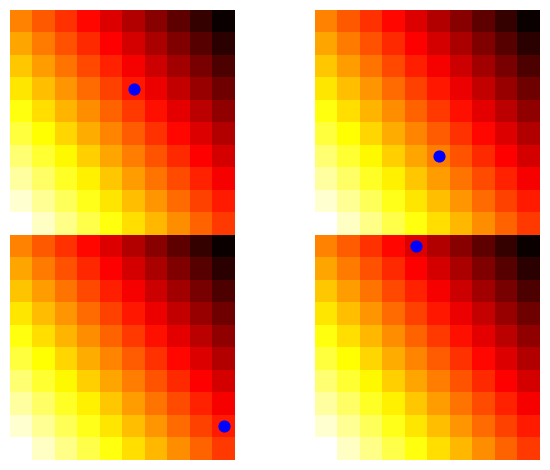


Updates 310, Steps 1990400, FPS 9824
Over the last 10 episodes:
    - episode.reward: -0.36749325080965145
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3938058742969615
    - inferred_episode_reward: 7.939693981409073
    - value_loss: 8.894132137298584
    - action_loss: -0.004463542869780212
    - dist_entropy: 5.672203445434571
    - irl_loss: 0.31080661714076996


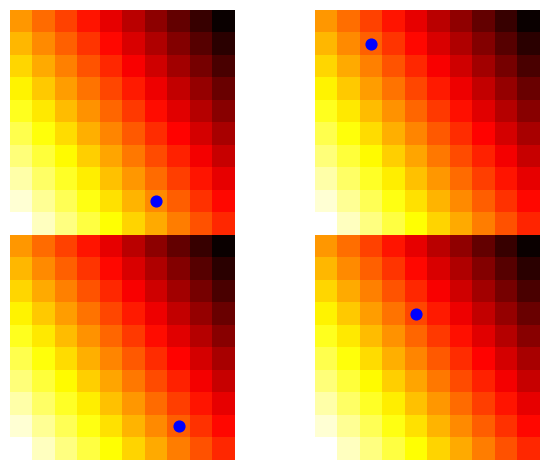


Updates 320, Steps 2054400, FPS 9679
Over the last 10 episodes:
    - episode.reward: -0.0936963178625841
    - episode.score: 0.1
    - episode.distance_to_goal: 0.3371445128566832
    - inferred_episode_reward: 4.8883415222167965
    - value_loss: 9.162658309936523
    - action_loss: -0.008376804538966099
    - dist_entropy: 5.672283363342285
    - irl_loss: 0.3097400158643723


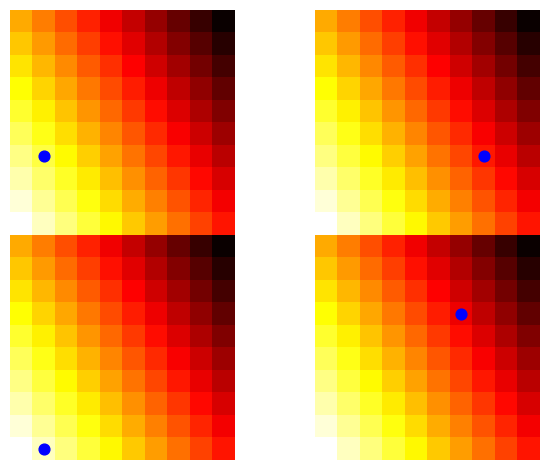


Updates 330, Steps 2118400, FPS 9704
Over the last 10 episodes:
    - episode.reward: -0.1527461203725156
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3559946800136178
    - inferred_episode_reward: 8.984985786676408
    - value_loss: 8.994548034667968
    - action_loss: -0.006265156035078689
    - dist_entropy: 5.673523902893066
    - irl_loss: 0.3231943190097809


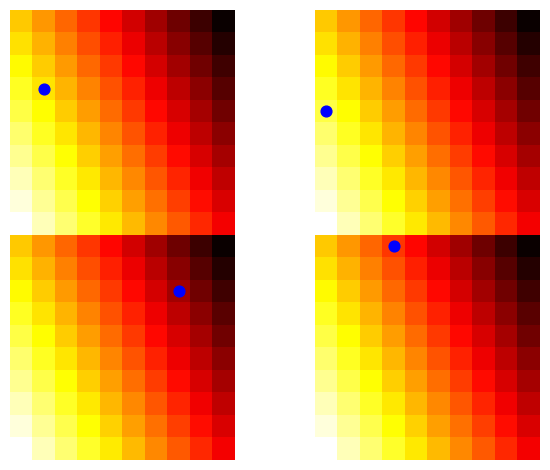


Updates 340, Steps 2182400, FPS 9831
Over the last 10 episodes:
    - episode.reward: -0.15827050153718608
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4276172755193346
    - inferred_episode_reward: 5.354363250732422
    - value_loss: 9.32699728012085
    - action_loss: -0.007713857037015259
    - dist_entropy: 5.673882961273193
    - irl_loss: 0.3246199250221252


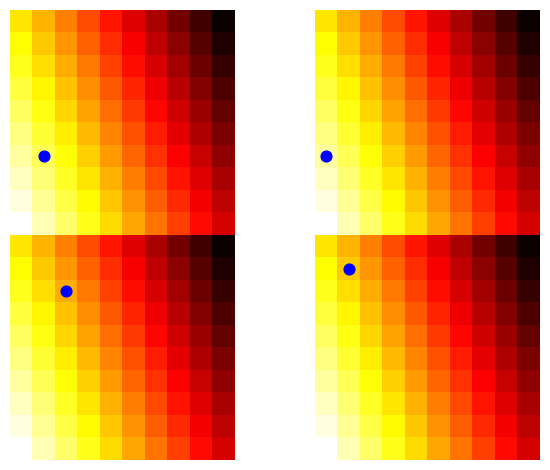


Updates 350, Steps 2246400, FPS 9655
Over the last 10 episodes:
    - episode.reward: -0.17878010594050978
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3890410744668036
    - inferred_episode_reward: 5.821650451421737
    - value_loss: 9.921154499053955
    - action_loss: -0.003517550101969391
    - dist_entropy: 5.6742829322814945
    - irl_loss: 0.3228251665830612


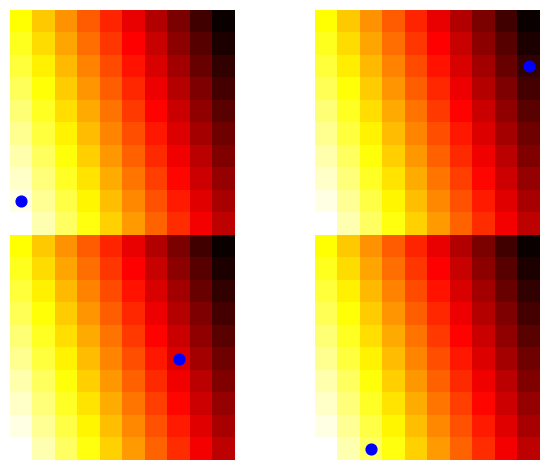


Updates 360, Steps 2310400, FPS 9696
Over the last 10 episodes:
    - episode.reward: -0.13966346043096606
    - episode.score: 0.0
    - episode.distance_to_goal: 0.42083921080856435
    - inferred_episode_reward: 7.100793808698654
    - value_loss: 10.75496530532837
    - action_loss: 0.003557571559213102
    - dist_entropy: 5.674362659454346
    - irl_loss: 0.320681232213974


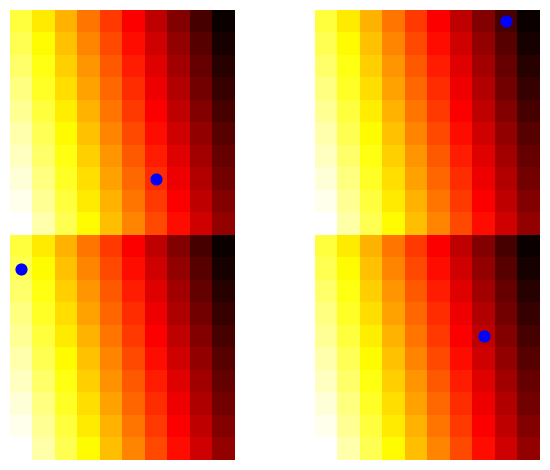


Updates 370, Steps 2374400, FPS 9802
Over the last 10 episodes:
    - episode.reward: -0.12901592426721648
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3654994609512446
    - inferred_episode_reward: 9.120779991149902
    - value_loss: 11.513312149047852
    - action_loss: 0.0040997194242663685
    - dist_entropy: 5.674562931060791
    - irl_loss: 0.3202877640724182


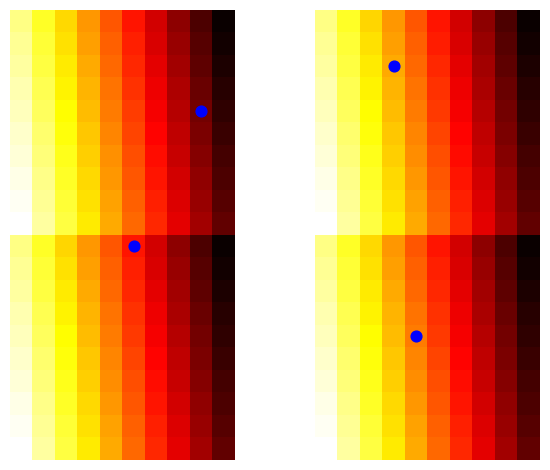


Updates 380, Steps 2438400, FPS 9824
Over the last 10 episodes:
    - episode.reward: -0.18503740286741338
    - episode.score: 0.0
    - episode.distance_to_goal: 0.49741258729313415
    - inferred_episode_reward: 11.214803194999694
    - value_loss: 13.198490047454834
    - action_loss: 0.0018490699119865894
    - dist_entropy: 5.675522136688232
    - irl_loss: 0.32693335711956023


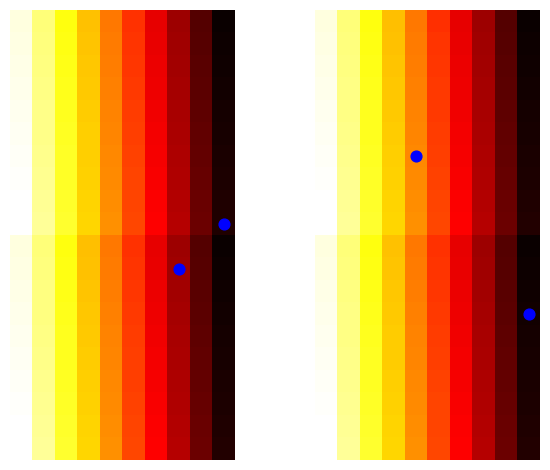


Updates 390, Steps 2502400, FPS 9649
Over the last 10 episodes:
    - episode.reward: -0.2137570329372492
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3049613484671616
    - inferred_episode_reward: 6.165344387292862
    - value_loss: 14.86262845993042
    - action_loss: 0.004006283264607191
    - dist_entropy: 5.675163841247558
    - irl_loss: 0.3243172734975815


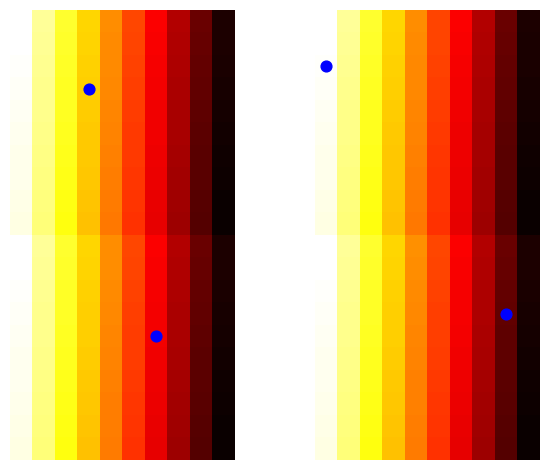


Updates 400, Steps 2566400, FPS 9687
Over the last 10 episodes:
    - episode.reward: -0.06860827745093055
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3522398936270281
    - inferred_episode_reward: 6.832423907518387
    - value_loss: 15.899361705780029
    - action_loss: 0.001247494562267093
    - dist_entropy: 5.675123691558838
    - irl_loss: 0.3272546350955963


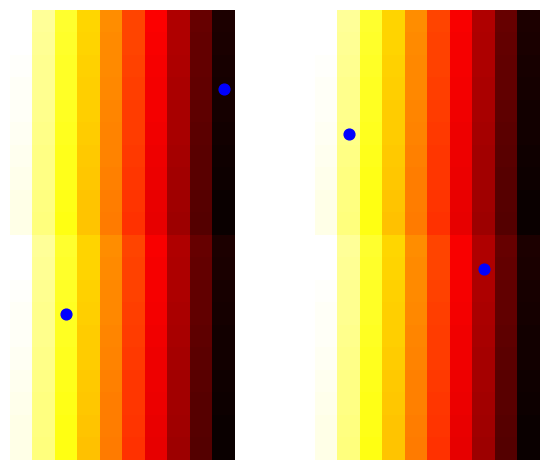


Updates 410, Steps 2630400, FPS 9745
Over the last 10 episodes:
    - episode.reward: -0.14426485665831087
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4251012376249495
    - inferred_episode_reward: 11.185172760486603
    - value_loss: 14.690059852600097
    - action_loss: 0.003327384125441313
    - dist_entropy: 5.6751633644104
    - irl_loss: 0.3320925414562225


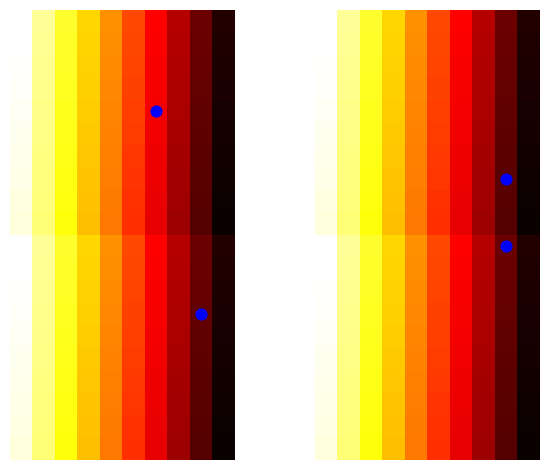


Updates 420, Steps 2694400, FPS 9732
Over the last 10 episodes:
    - episode.reward: -0.04031603123123488
    - episode.score: 0.0
    - episode.distance_to_goal: 0.39236886512108554
    - inferred_episode_reward: 11.344281768798828
    - value_loss: 16.71059684753418
    - action_loss: -0.0039706012234091755
    - dist_entropy: 5.675001621246338
    - irl_loss: 0.3272006332874298


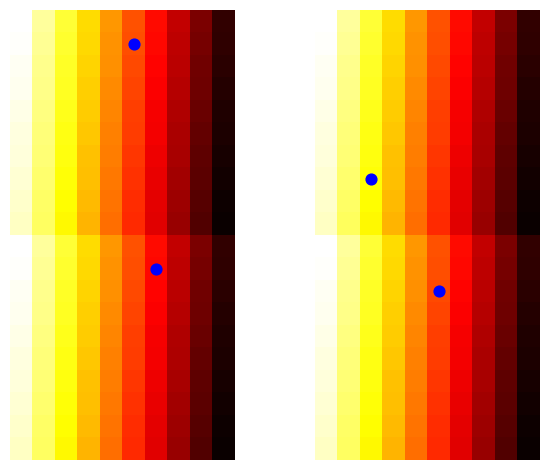


Updates 430, Steps 2758400, FPS 9476
Over the last 10 episodes:
    - episode.reward: -0.38379513204460125
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3920393247627693
    - inferred_episode_reward: 17.549939823150634
    - value_loss: 20.49907398223877
    - action_loss: -0.006809255690313876
    - dist_entropy: 5.675561046600341
    - irl_loss: 0.3249961346387863


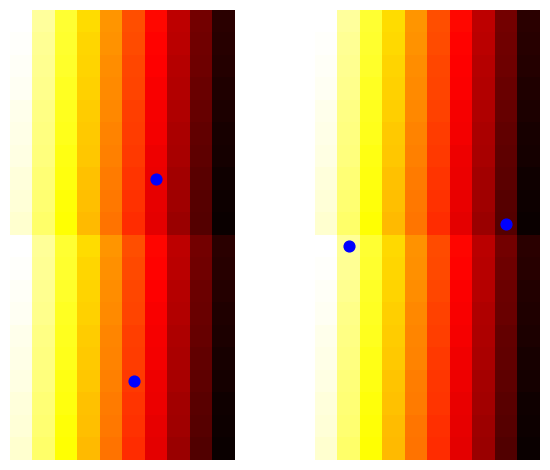


Updates 440, Steps 2822400, FPS 9262
Over the last 10 episodes:
    - episode.reward: -0.16883006237078668
    - episode.score: 0.0
    - episode.distance_to_goal: 0.42252411019119285
    - inferred_episode_reward: 14.014431738853455
    - value_loss: 27.369582748413087
    - action_loss: -0.007318470838072244
    - dist_entropy: 5.674841403961182
    - irl_loss: 0.323591023683548


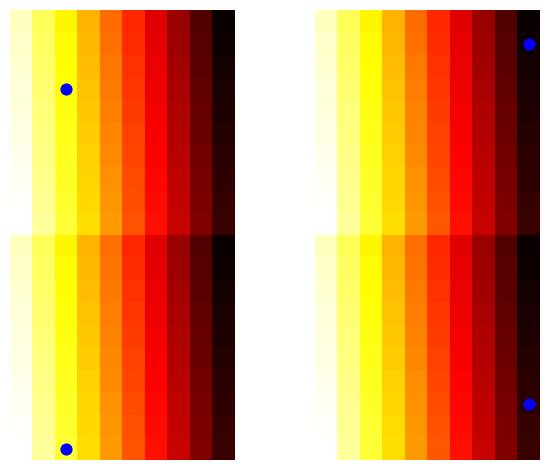


Updates 450, Steps 2886400, FPS 9421
Over the last 10 episodes:
    - episode.reward: -0.028754426248088594
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3262587969035587
    - inferred_episode_reward: 12.908692753314972
    - value_loss: 28.439815711975097
    - action_loss: -0.00534946951083839
    - dist_entropy: 5.67492151260376
    - irl_loss: 0.31672423183917997


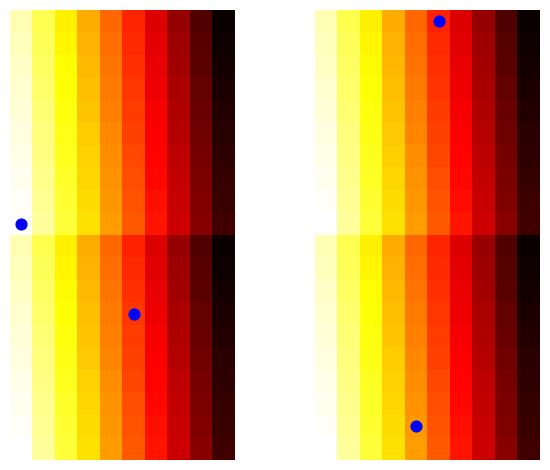


Updates 460, Steps 2950400, FPS 9953
Over the last 10 episodes:
    - episode.reward: -0.15400729316043288
    - episode.score: 0.0
    - episode.distance_to_goal: 0.37381559865503833
    - inferred_episode_reward: 13.072111415863038
    - value_loss: 31.983400535583495
    - action_loss: -0.00545188671676442
    - dist_entropy: 5.675520992279052
    - irl_loss: 0.3104353964328766


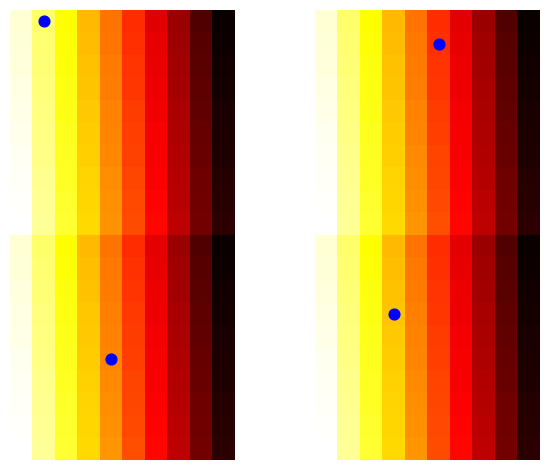


Updates 470, Steps 3014400, FPS 9661
Over the last 10 episodes:
    - episode.reward: -0.2560437380892465
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3789172327300674
    - inferred_episode_reward: 14.457564306259155
    - value_loss: 29.56923656463623
    - action_loss: 0.004053528331860434
    - dist_entropy: 5.675161838531494
    - irl_loss: 0.31224140524864197


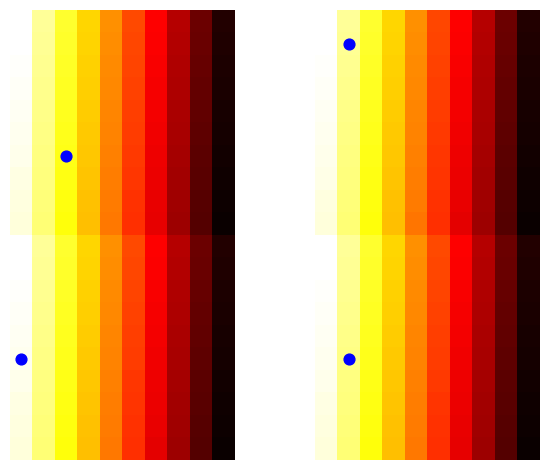


Updates 480, Steps 3078400, FPS 9684
Over the last 10 episodes:
    - episode.reward: -0.04229656839483127
    - episode.score: 0.0
    - episode.distance_to_goal: 0.35296755342939173
    - inferred_episode_reward: 14.399034070968629
    - value_loss: 31.332046508789062
    - action_loss: 0.005071434349520132
    - dist_entropy: 5.67620210647583
    - irl_loss: 0.31450271904468535


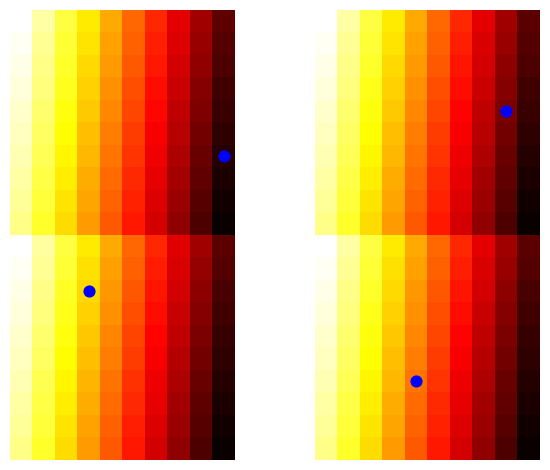


Updates 490, Steps 3142400, FPS 9713
Over the last 10 episodes:
    - episode.reward: -0.03806605531944676
    - episode.score: 0.0
    - episode.distance_to_goal: 0.30829117960486796
    - inferred_episode_reward: 14.368456935882568
    - value_loss: 34.800911331176756
    - action_loss: 0.0036067059729248284
    - dist_entropy: 5.676920795440674
    - irl_loss: 0.3277470499277115


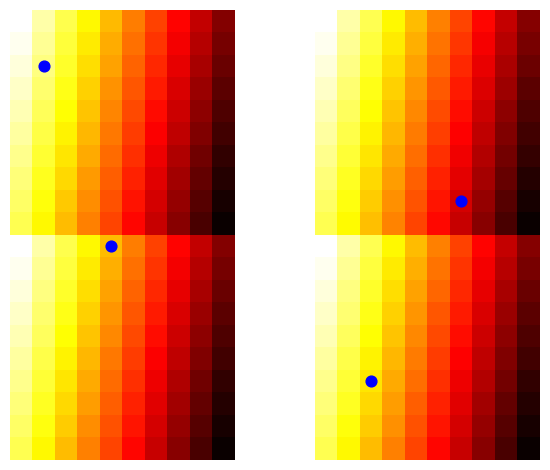


Updates 500, Steps 3206400, FPS 9342
Over the last 10 episodes:
    - episode.reward: -0.055913977098243195
    - episode.score: 0.0
    - episode.distance_to_goal: 0.399134684782953
    - inferred_episode_reward: 25.984881889820098
    - value_loss: 38.4922290802002
    - action_loss: -0.006273604859597981
    - dist_entropy: 5.676481151580811
    - irl_loss: 0.3375410556793213


<Figure size 640x480 with 0 Axes>

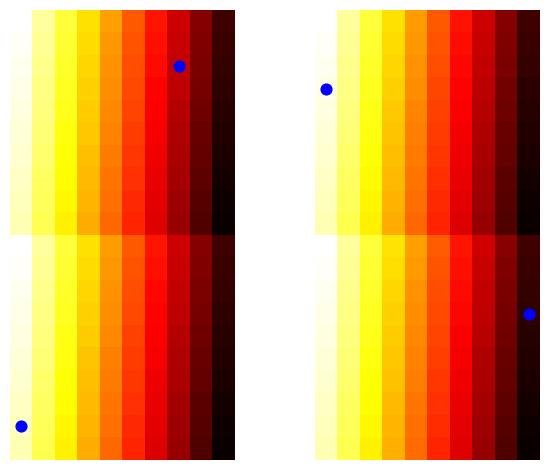


Updates 510, Steps 3270400, FPS 7766
Over the last 10 episodes:
    - episode.reward: -0.14254409043092187
    - episode.score: 0.0
    - episode.distance_to_goal: 0.42663605255681125
    - inferred_episode_reward: 17.558904469013214
    - value_loss: 46.141591262817386
    - action_loss: -0.0036507263546809556
    - dist_entropy: 5.676361560821533
    - irl_loss: 0.33379686176776885


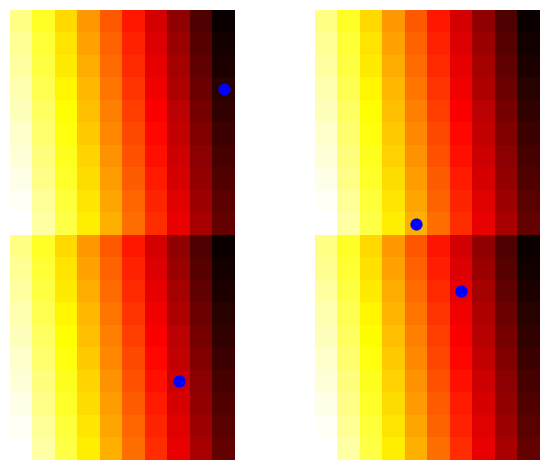


Updates 520, Steps 3334400, FPS 8871
Over the last 10 episodes:
    - episode.reward: -0.056451480980382565
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3893941240674897
    - inferred_episode_reward: 14.867236638069153
    - value_loss: 45.961687850952146
    - action_loss: 0.003171302200644277
    - dist_entropy: 5.676720523834229
    - irl_loss: 0.33300502598285675


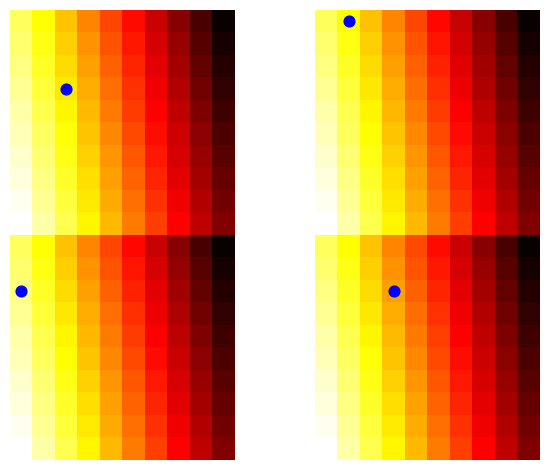


Updates 530, Steps 3398400, FPS 9748
Over the last 10 episodes:
    - episode.reward: -0.1682078754315775
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3744083384204256
    - inferred_episode_reward: 17.515529918670655
    - value_loss: 43.553381729125974
    - action_loss: 0.004360833810642362
    - dist_entropy: 5.67620210647583
    - irl_loss: 0.3351033300161362


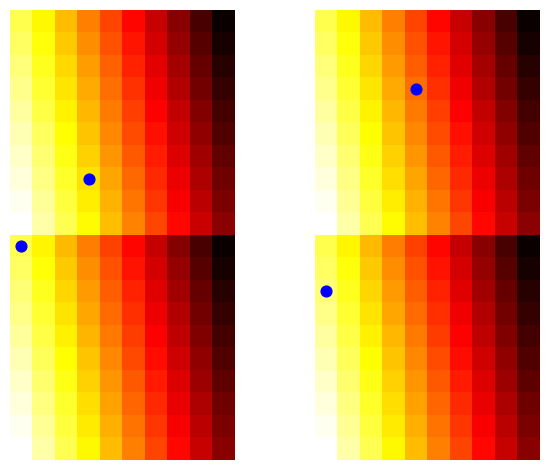


Updates 540, Steps 3462400, FPS 9836
Over the last 10 episodes:
    - episode.reward: -0.05348004546477114
    - episode.score: 0.0
    - episode.distance_to_goal: 0.30361258633099136
    - inferred_episode_reward: 22.381587791442872
    - value_loss: 42.6855224609375
    - action_loss: -0.003447650675661862
    - dist_entropy: 5.676760196685791
    - irl_loss: 0.33520340025424955


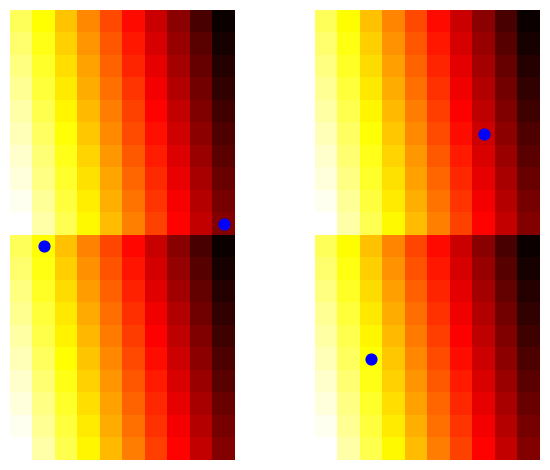


Updates 550, Steps 3526400, FPS 9705
Over the last 10 episodes:
    - episode.reward: -0.14117007269514675
    - episode.score: 0.0
    - episode.distance_to_goal: 0.30288811532791177
    - inferred_episode_reward: 26.846980571746826
    - value_loss: 46.239606094360354
    - action_loss: -0.005046703619882464
    - dist_entropy: 5.677641773223877
    - irl_loss: 0.3345489054918289


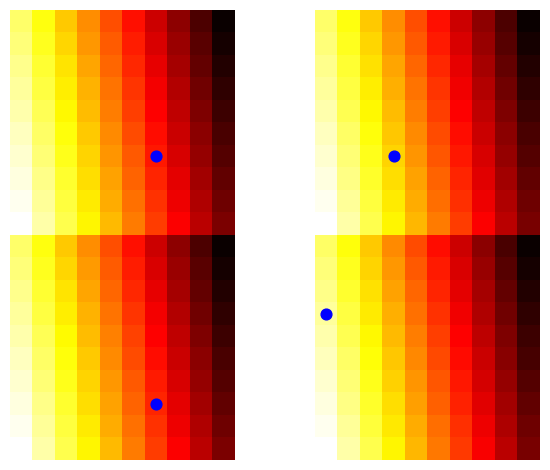


Updates 560, Steps 3590400, FPS 9602
Over the last 10 episodes:
    - episode.reward: -0.06701146323568427
    - episode.score: 0.0
    - episode.distance_to_goal: 0.2735836735997275
    - inferred_episode_reward: 18.509058892726898
    - value_loss: 48.18869514465332
    - action_loss: 0.00545849499758333
    - dist_entropy: 5.678121948242188
    - irl_loss: 0.33427446484565737


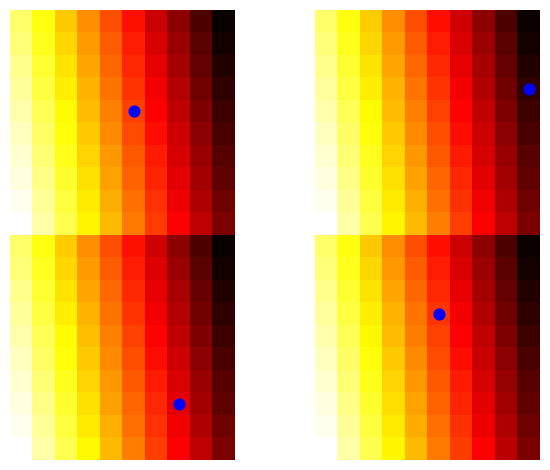


Updates 570, Steps 3654400, FPS 9816
Over the last 10 episodes:
    - episode.reward: 0.08000387204128434
    - episode.score: 0.1
    - episode.distance_to_goal: 0.2942649031119709
    - inferred_episode_reward: 19.33054575920105
    - value_loss: 59.66302719116211
    - action_loss: -0.0043773205485194925
    - dist_entropy: 5.678961753845215
    - irl_loss: 0.334725496172905


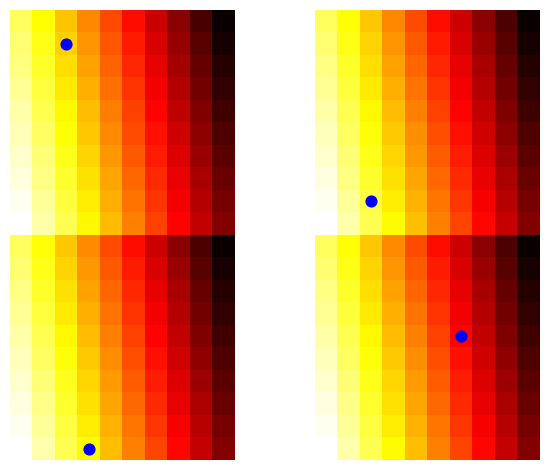


Updates 580, Steps 3718400, FPS 9684
Over the last 10 episodes:
    - episode.reward: -0.06854023560847397
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3468230701423133
    - inferred_episode_reward: 25.64906711578369
    - value_loss: 57.853725814819335
    - action_loss: -0.011893942020833492
    - dist_entropy: 5.679602909088135
    - irl_loss: 0.33004270792007445


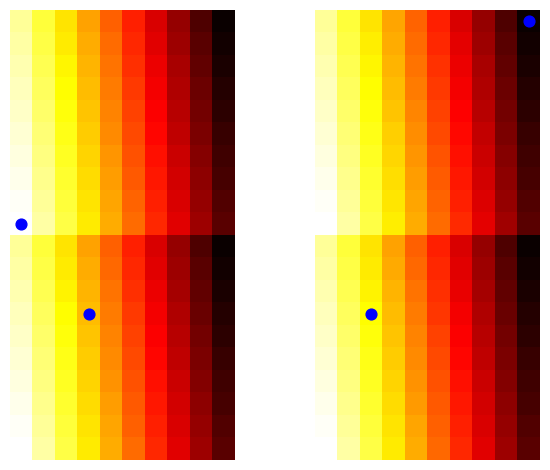


Updates 590, Steps 3782400, FPS 9138
Over the last 10 episodes:
    - episode.reward: -0.18324789317130208
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3857675634178548
    - inferred_episode_reward: 35.96797380447388
    - value_loss: 58.98904113769531
    - action_loss: -0.0010549569735303522
    - dist_entropy: 5.679361152648926
    - irl_loss: 0.327196279168129


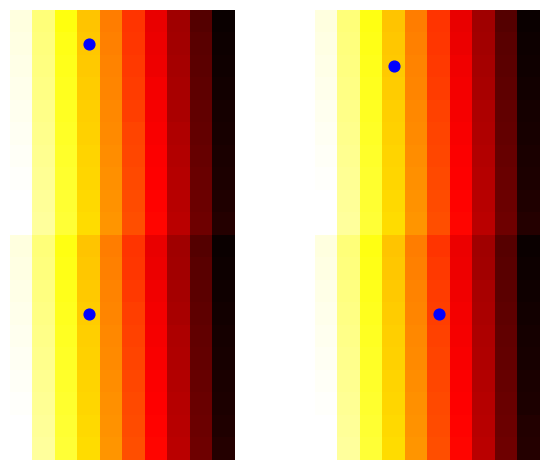


Updates 600, Steps 3846400, FPS 9738
Over the last 10 episodes:
    - episode.reward: 0.0548609276229569
    - episode.score: 0.1
    - episode.distance_to_goal: 0.36196903042600076
    - inferred_episode_reward: 16.928357672691345
    - value_loss: 54.91780395507813
    - action_loss: 0.01174139806535095
    - dist_entropy: 5.6793210983276365
    - irl_loss: 0.3372910261154175


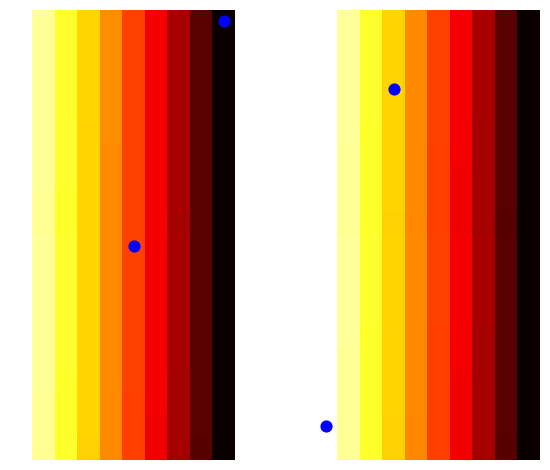


Updates 610, Steps 3910400, FPS 9466
Over the last 10 episodes:
    - episode.reward: -0.05723874997835528
    - episode.score: 0.0
    - episode.distance_to_goal: 0.41161273701025686
    - inferred_episode_reward: 25.12332444190979
    - value_loss: 58.40453186035156
    - action_loss: 0.004464893380645663
    - dist_entropy: 5.6789626121521
    - irl_loss: 0.33512524962425233


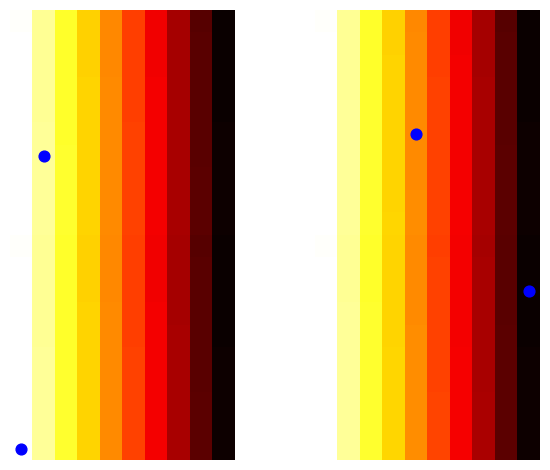


Updates 620, Steps 3974400, FPS 9144
Over the last 10 episodes:
    - episode.reward: -0.05354398274445939
    - episode.score: 0.0
    - episode.distance_to_goal: 0.39816773724303833
    - inferred_episode_reward: 13.43321534395218
    - value_loss: 52.01090431213379
    - action_loss: -0.016893964691553263
    - dist_entropy: 5.679563045501709
    - irl_loss: 0.33713618516921995


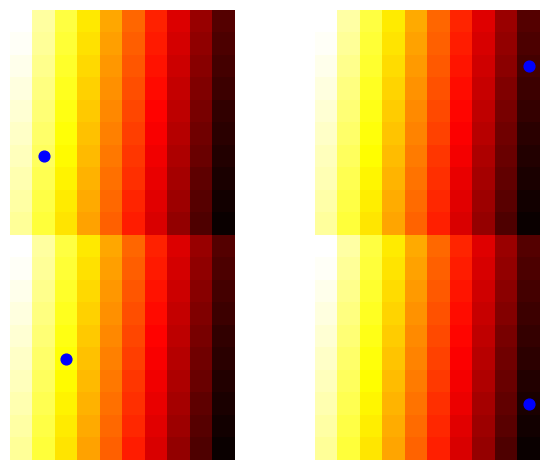


Updates 630, Steps 4038400, FPS 9690
Over the last 10 episodes:
    - episode.reward: -0.025958225835718978
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3202599960671265
    - inferred_episode_reward: 10.618437373638153
    - value_loss: 46.0403865814209
    - action_loss: -0.005480529426131397
    - dist_entropy: 5.679683589935303
    - irl_loss: 0.33607566058635713


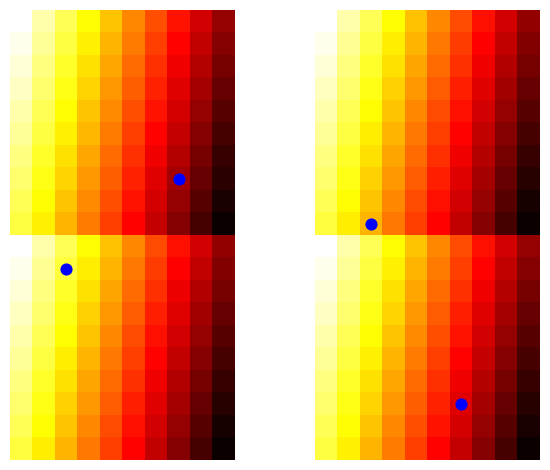


Updates 640, Steps 4102400, FPS 9749
Over the last 10 episodes:
    - episode.reward: -0.12238611646085881
    - episode.score: 0.0
    - episode.distance_to_goal: 0.27131343384412576
    - inferred_episode_reward: 14.206495332717896
    - value_loss: 45.39947662353516
    - action_loss: -0.002432365855202079
    - dist_entropy: 5.6801228523254395
    - irl_loss: 0.3366043210029602


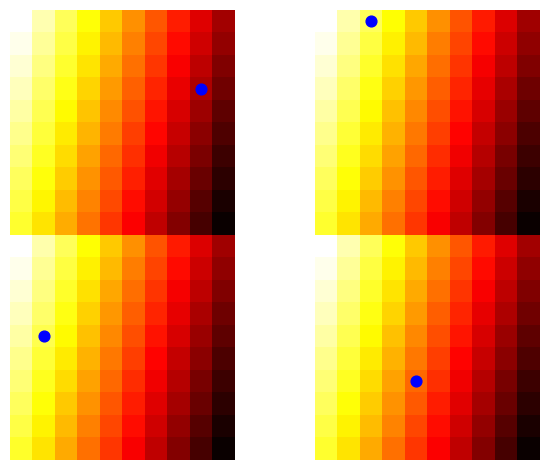


Updates 650, Steps 4166400, FPS 9607
Over the last 10 episodes:
    - episode.reward: -0.13411352937697094
    - episode.score: 0.1
    - episode.distance_to_goal: 0.350602356650644
    - inferred_episode_reward: 10.063638150691986
    - value_loss: 40.96972312927246
    - action_loss: -0.008178478796980925
    - dist_entropy: 5.681082725524902
    - irl_loss: 0.34323052167892454


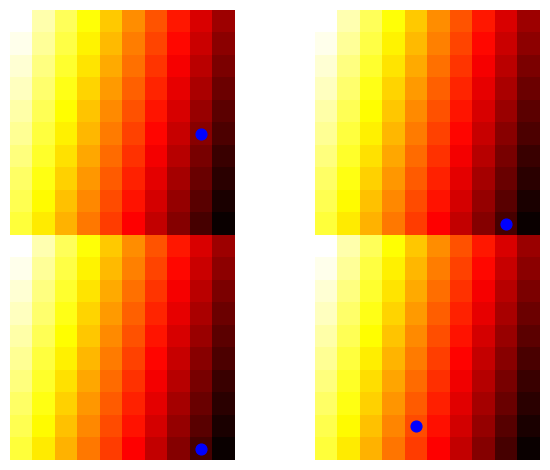


Updates 660, Steps 4230400, FPS 9670
Over the last 10 episodes:
    - episode.reward: -0.058865469264003156
    - episode.score: 0.0
    - episode.distance_to_goal: 0.4194445025679648
    - inferred_episode_reward: 15.388256549835205
    - value_loss: 43.551849365234375
    - action_loss: 0.009531131037510932
    - dist_entropy: 5.680962562561035
    - irl_loss: 0.3456249088048935


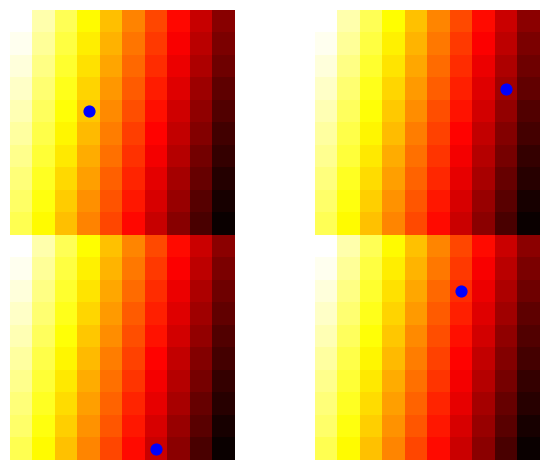


Updates 670, Steps 4294400, FPS 9745
Over the last 10 episodes:
    - episode.reward: -0.14195699816899043
    - episode.score: 0.0
    - episode.distance_to_goal: 0.37017473246692567
    - inferred_episode_reward: 15.318157267570495
    - value_loss: 43.12263374328613
    - action_loss: 0.0014890672697219997
    - dist_entropy: 5.681683158874511
    - irl_loss: 0.3526885390281677


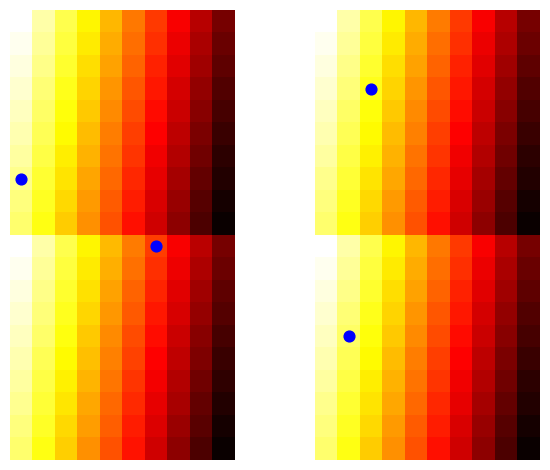


Updates 680, Steps 4358400, FPS 9905
Over the last 10 episodes:
    - episode.reward: -0.18050483173487436
    - episode.score: 0.0
    - episode.distance_to_goal: 0.43298309195631307
    - inferred_episode_reward: 11.856840324401855
    - value_loss: 44.48779220581055
    - action_loss: 0.010753622138872742
    - dist_entropy: 5.681363105773926
    - irl_loss: 0.3505953222513199


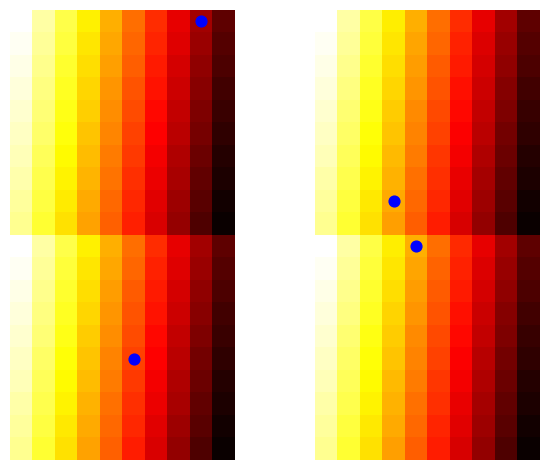


Updates 690, Steps 4422400, FPS 9668
Over the last 10 episodes:
    - episode.reward: -0.15495160188266519
    - episode.score: 0.0
    - episode.distance_to_goal: 0.373715971767019
    - inferred_episode_reward: 29.09548637866974
    - value_loss: 43.57885894775391
    - action_loss: 0.007554496033117175
    - dist_entropy: 5.681562900543213
    - irl_loss: 0.34743943214416506


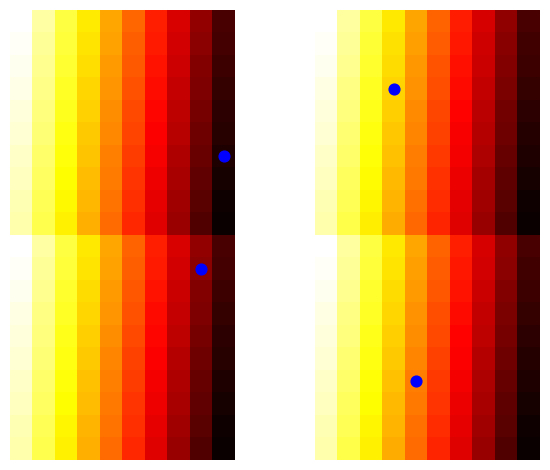


Updates 700, Steps 4486400, FPS 9728
Over the last 10 episodes:
    - episode.reward: -0.3301992471844145
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3875238280149541
    - inferred_episode_reward: 34.51424293518066
    - value_loss: 40.67010345458984
    - action_loss: -0.007349154731491581
    - dist_entropy: 5.681363105773926
    - irl_loss: 0.345411679148674


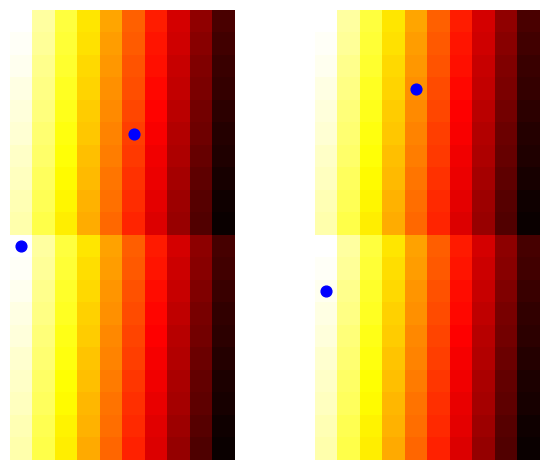


Updates 710, Steps 4550400, FPS 9743
Over the last 10 episodes:
    - episode.reward: -0.141087606166267
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3261109092819362
    - inferred_episode_reward: 10.998623991012574
    - value_loss: 37.942251205444336
    - action_loss: -0.009909700718708336
    - dist_entropy: 5.681403064727784
    - irl_loss: 0.3473710924386978


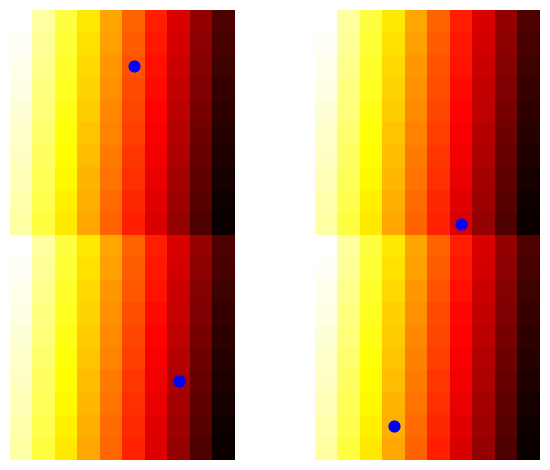


Updates 720, Steps 4614400, FPS 9956
Over the last 10 episodes:
    - episode.reward: -0.15703476603572258
    - episode.score: 0.0
    - episode.distance_to_goal: 0.44573913050310576
    - inferred_episode_reward: 13.13248348236084
    - value_loss: 35.283481979370116
    - action_loss: -0.004252238152548671
    - dist_entropy: 5.6817626953125
    - irl_loss: 0.3552179217338562


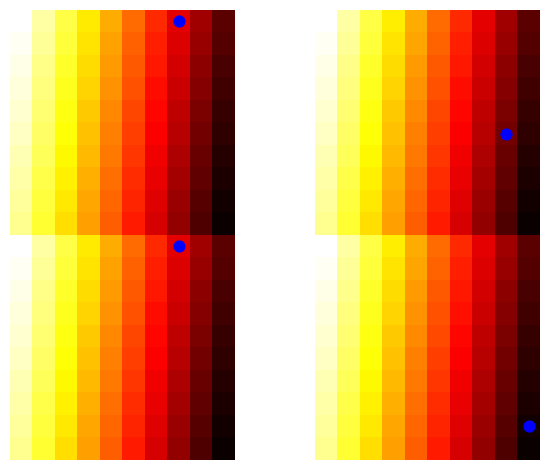


Updates 730, Steps 4678400, FPS 9739
Over the last 10 episodes:
    - episode.reward: -0.040279499881267236
    - episode.score: 0.0
    - episode.distance_to_goal: 0.35002177579178223
    - inferred_episode_reward: 21.552130699157715
    - value_loss: 38.49870681762695
    - action_loss: -0.0071940596564672886
    - dist_entropy: 5.681722736358642
    - irl_loss: 0.35934138894081114


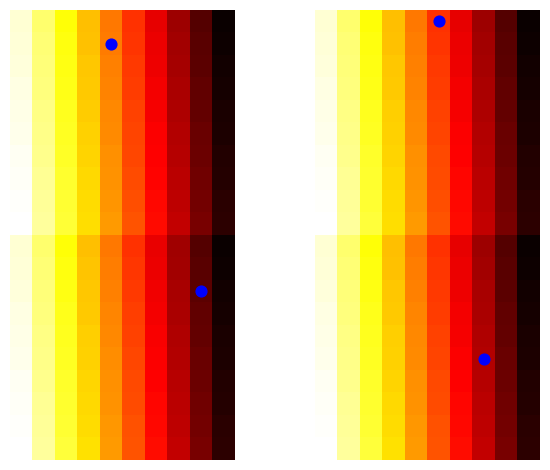


Updates 740, Steps 4742400, FPS 9771
Over the last 10 episodes:
    - episode.reward: -0.05213614946337196
    - episode.score: 0.0
    - episode.distance_to_goal: 0.31376592827793465
    - inferred_episode_reward: 28.714722561836243
    - value_loss: 107.36981658935547
    - action_loss: 0.0025793902575969698
    - dist_entropy: 5.682562828063965
    - irl_loss: 0.355385759472847


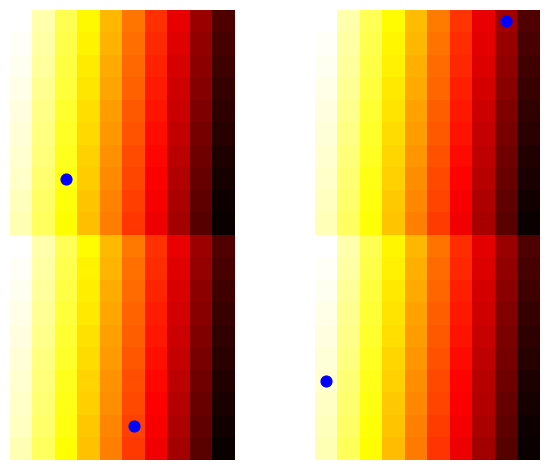


Updates 750, Steps 4806400, FPS 9712
Over the last 10 episodes:
    - episode.reward: -0.04480044989204756
    - episode.score: 0.0
    - episode.distance_to_goal: 0.35474075473783967
    - inferred_episode_reward: 40.403865337371826
    - value_loss: 213.82315216064453
    - action_loss: -0.0047018668963573875
    - dist_entropy: 5.682560920715332
    - irl_loss: 0.3452150195837021


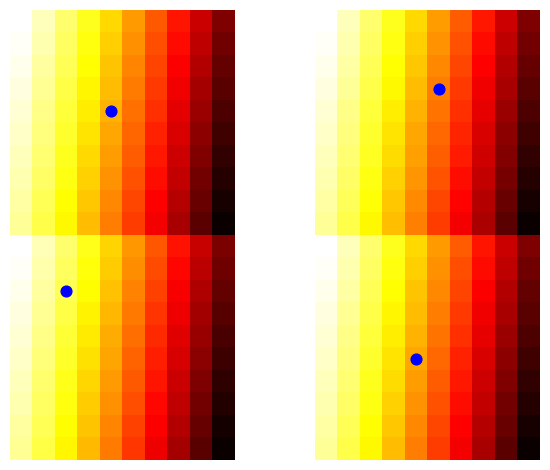


Updates 760, Steps 4870400, FPS 9872
Over the last 10 episodes:
    - episode.reward: -0.14102417359433808
    - episode.score: 0.0
    - episode.distance_to_goal: 0.323537791103536
    - inferred_episode_reward: 40.77883166074753
    - value_loss: 245.66174926757813
    - action_loss: 0.008741353498771786
    - dist_entropy: 5.682440376281738
    - irl_loss: 0.34673078656196593


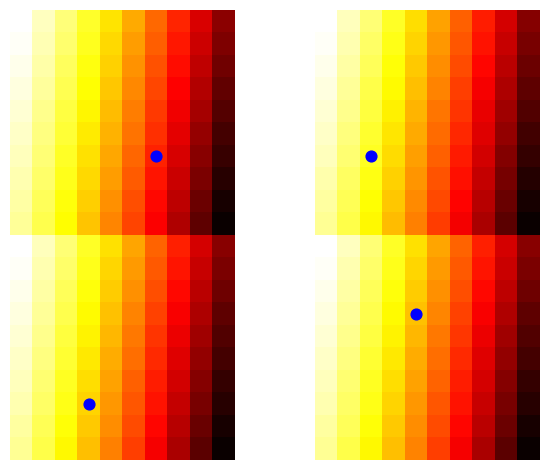


Updates 770, Steps 4934400, FPS 9729
Over the last 10 episodes:
    - episode.reward: -0.15555683654060432
    - episode.score: 0.0
    - episode.distance_to_goal: 0.3453111026475166
    - inferred_episode_reward: 48.7061110496521
    - value_loss: 277.2355895996094
    - action_loss: 0.0030953841283917426
    - dist_entropy: 5.68295955657959
    - irl_loss: 0.34722853302955625


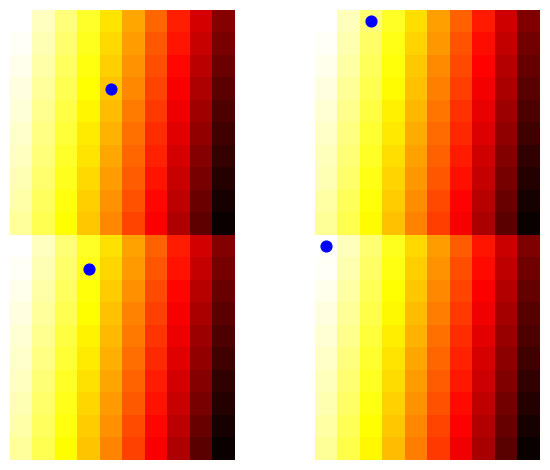


Updates 780, Steps 4998400, FPS 9737
Over the last 10 episodes:
    - episode.reward: -0.2670247843445304
    - episode.score: 0.0
    - episode.distance_to_goal: 0.36594945470885687
    - inferred_episode_reward: 48.20310641527176
    - value_loss: 256.76825561523435
    - action_loss: -0.001616979786194861
    - dist_entropy: 5.683641529083252
    - irl_loss: 0.35037291049957275


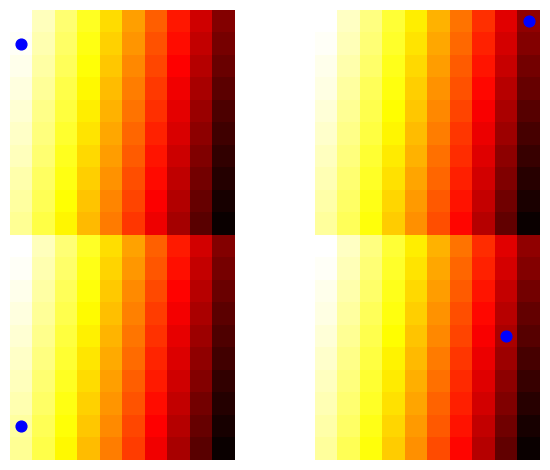

Saved to ./data/checkpoints/64-3-HfuzZX/ckpt.780.pth
{'run_name': '64-3-HfuzZX', 'last_ckpt': './data/checkpoints/64-3-HfuzZX/ckpt.780.pth'}


In [44]:




# Storage for the rollouts
obs = envs.reset()
td = TensorDict({"observation": obs}, batch_size=[cfg.num_envs])

# Storage for the rollouts
storage_td = TensorDict({}, batch_size=[cfg.num_envs, cfg.num_steps], device=device)

for update_i in range(start_update, num_updates):
    is_last_update = update_i == num_updates - 1
    for step_idx in range(cfg.num_steps):

        # Collect experience.
        with torch.no_grad():
            policy.act(td)
        next_obs, reward, done, infos = envs.step(td["action"])

        td["next_observation"] = next_obs
        for env_i, info in enumerate(infos):
            if "final_obs" in info:
                td["next_observation"][env_i] = info["final_obs"]
        td["reward"] = reward.reshape(-1, 1)
        td["done"] = done
    
        storage_td[:, step_idx] = td

        # Log to CLI/wandb.
        logger.collect_env_step_info(infos)
    
    # Call method specific update function
    updater.update(policy, storage_td, logger, envs=envs)



    if cfg.log_interval != -1 and (
        update_i % cfg.log_interval == 0 or is_last_update
    ):
        logger.interval_log(update_i, steps_per_update * (update_i + 1))
        height = 2
        width = 2
        eval_env = SnakeEnv(cfg.env.env_settings.params.config)
        fig, ax = plt.subplots(nrows=height, ncols=width, sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace': 0})

        last_reward_map = np.zeros((eval_env.screen_width//eval_env.block_size, eval_env.screen_height//eval_env.block_size))

        for i in range(height):
            for j in range(width):
                
                reward_map = np.zeros((eval_env.screen_width//eval_env.block_size, eval_env.screen_height//eval_env.block_size))
                apple_pos = eval_env.reset()[0][:2]
                #test what you got so far by plotting a heat map of the reward using the snake only 
                for x in range(eval_env.screen_width//eval_env.block_size):
                    for y in range(eval_env.screen_height//eval_env.block_size ):
                        x_grid = x * eval_env.block_size / eval_env.screen_width
                        y_grid = y * eval_env.block_size / eval_env.screen_height
                        reward_map[x,y] = updater.reward(next_obs = torch.tensor([*apple_pos,x_grid,y_grid]+[0]*(eval_env.observation_space.shape[0]-4),dtype=torch.float32).to(device).view(1,1,-1))
                # for x in range(eval_env.screen_width//eval_env.block_size):
                #     for y in range(eval_env.screen_height//eval_env.block_size ):
                #         print(f"{reward_map[x,y]:.2f}", end=" ")
                #     print()
                    
                # Define the color map
                cmap = plt.cm.get_cmap('hot')

                # Plot the reward map without axis and numbers
                image = ax[i,j].imshow(reward_map, cmap=cmap, interpolation='nearest')
                ax[i,j].axis('off')

                # Plot the apple
                ax[i,j].scatter(
                    apple_pos[1] * eval_env.screen_height // eval_env.block_size,
                    apple_pos[0] * eval_env.screen_width // eval_env.block_size,
                    c='blue',
                    s=60
                )
                # map_diff = reward_map - last_reward_map
                # for x in range(eval_env.screen_width//eval_env.block_size):
                #     for y in range(eval_env.screen_height//eval_env.block_size ):
                #          print(f"{reward_map[x,y]:.2f}", end=" ")
                #     print()
                    
                # print("reward_maps diff " ,np.linalg.norm(reward_map-last_reward_map))
                last_reward_map = reward_map
        plt.tight_layout()
        plt.show()
        # for x in range(eval_env.screen_width//eval_env.block_size):
        #     for y in range(eval_env.screen_height//eval_env.block_size ):
        #         print(f"{reward_map[x,y]:.2f}", end=" ")
        #     print()

    if cfg.save_interval != -1 and (
        (update_i + 1) % cfg.save_interval == 0 or is_last_update
    ):
        save_name = osp.join(logger.save_path, f"ckpt.{update_i}.pth")
        torch.save(
            {
                "policy": policy.state_dict(),
                "updater": updater.state_dict(),
                "update_i": update_i,
            },
            save_name,
        )
        print(f"Saved to {save_name}")
        eval_info["last_ckpt"] = save_name

logger.close()
print(eval_info)

In [45]:
ckpt = torch.load(save_name)
updater.load_state_dict(ckpt["updater"], should_load_opt=cfg.resume_training)
policy.load_state_dict(ckpt["policy"])


<All keys matched successfully>

In [46]:
import pygame

In [47]:
cfg.env.env_settings.params.config["render_mode"] = "human"

In [48]:
envs = vectorized_env([SnakeEnv(cfg.env.env_settings.params.config) for _ in range(cfg.num_envs)])

while True:

    obs = envs.reset()
    td = TensorDict({"observation": obs}, batch_size=cfg.num_envs)
    terminated = False 
    while not terminated : 
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()

        with torch.no_grad():
            policy.act(td)
        next_obs, reward, done, infos = envs.step(td["action"])
        envs.render(mode="human")
        td["next_observation"] = next_obs
        td["reward"] = reward.reshape(-1, 1)

        td["done"] = done

        td["observation"] = next_obs
        terminated = done[0]
        # Log to CLI/wandb.
        logger.collect_env_step_info(infos)
        pygame.time.wait(100)

error: display Surface quit